# Thermodynamics of NaCl's Effects on the Solubility of Polyethylene Glycol (POSTER)
Stefan Hervø-Hansen<sup>a</sup>, Jan Heyda<sup>b</sup>, and Nobuyuki Matubayasi<sup>a</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>b</sup> Department of Physical Chemistry, University of Chemistry and Technology, Prague CZ-16628, Czech Republic.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp

## Import of Python Modules & Auxiliary Functions

In [1]:
#Notebook dependent libs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import mdtraj as md
from mdtraj.utils import ensure_type
import re
import scipy.optimize as optimize
import scipy.ndimage as ndimage
from scipy.integrate import cumulative_trapezoid
from uncertainties import unumpy
from sklearn.decomposition import PCA
from multiprocessing import Pool
import scipy.stats as stats


from Auxiliary import fessa
plt.set_cmap('fessa')

# Physical constants & useful conversions
RT = 0.001987 * 298.15
Na = 6.02214076e23 # Avogadro constant [mol]
nm3_to_l = 1e-24

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"])
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams["text.usetex"] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

homedir = !pwd
homedir = homedir[0]
print(homedir)

/data/group1/z44785r/PEO-Solubility


<Figure size 640x480 with 0 Axes>

### Simulation settings

In [2]:
states = { # State of simulations, (outFreq is steps per frame)
          'conf':{'Nsteps': 500000000, 'OutFreq': 1000}, # 1000 nanoseconds, 500.000 frames
          'sol': {'Nsteps': 125000000, 'OutFreq':  500}, #  250 nanoseconds, 250.000 frames
          'ref': {'Nsteps':  50000000, 'OutFreq':  500}, #  100 nanoseconds, 100.000 frames
         }

nmers = [36] # PEG polymer length
Nparticles = {       # Number of PEG and water molecules. Salt is calculated based on concentration input
    'PEG': 1,
    'Water': 10000,
}
NConfs = 100

# Approximate concentrations of salt (in Molar) under which the structual sampling is conducted.
salt_reference_concentrations = { # P1 and P2 are the perturbations with the new number of salt particles.
   0.00: {'P0':   0,  'P1': 368, 'P2': 792, 'P3': 46, 'P4': 92, 'P5': 184, 'P6': 582, 'P7': 1000},
   0.25: {'P0':  46,  'P1':   0},
   0.50: {'P0':  92,  'P1':   0},
   1.00: {'P0': 184,  'P1':   0},
   2.00: {'P0': 368,  'P1':   0, 'P2': 792},
   3.00: {'P0': 582,  'P1':   0},
   4.00: {'P0': 792,  'P1':   0, 'P2': 368},
   5.00: {'P0': 1000, 'P1':   0}
}

salts = { # Types of salt added to the simulations.
         'NaCl'   : {'Cation': 'Na' , 'Anion': 'Cl' }
}

## Analysis of the Solvation Free Energies
### Definition of Solvent-integrated BAR functions

In [3]:
RT = 0.001987 * 298.15 # [kcal/mol]

def BAR_solvation_free_energy(D, state_A, state_B, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    # Asign two states
    dSLVFE_AB = state_A[1] - state_A[0]
    dSLVFE_BA = -(state_B[1] - state_B[0])
    
    # Initializing sum of Fermi-Dirac functions
    sum_f_ij = 0
    sum_f_ji = 0
    
    # Adding Fermi-Dirac function for each slvfe
    for dSLVFE in dSLVFE_AB:
        sum_f_ij += 1/(1+np.exp(-dSLVFE/RT+D))
    for dSLVFE in dSLVFE_BA:
        sum_f_ji += 1/(1+np.exp(dSLVFE/RT-D))
        
    # return squared diff. btw sums of Fermi-Dirac functions
    return (sum_f_ij - sum_f_ji)**2

def BAR_error_solvation_free_energy(D, state_A, state_B, state_A_errs, state_B_errs, T=298.15):
    RT = 0.001987 * T # [kcal/mol]
    
    def F(x): # Fermi-Dirac function
        return 1/(1+np.exp(x))
    def FF(x): # Eq. 21
        return -(1/RT)*F(x)*F(-x)
    
    # Asign two states (Propagation of errors)
    dSLVFE_AB = unumpy.uarray(state_A[1], state_A_errs[1]) - unumpy.uarray(state_A[0], state_A_errs[0])
    dSLVFE_BA = -(unumpy.uarray(state_B[1], state_B_errs[1]) - unumpy.uarray(state_B[0], state_B_errs[0]))
    
    # Calculate the denominator and store the nominators of Eq. 20 
    nominators = []
    denominator = 0
    for slvfe in [*unumpy.nominal_values(dSLVFE_AB), *unumpy.nominal_values(dSLVFE_BA)]:
        value = FF(D-slvfe)
        denominator += value
        nominators.append(value)
        
    # Summuation of the error (Eq. 19)
    BAR_error = 0
    for C, slvfe_err in zip(nominators, [*unumpy.std_devs(dSLVFE_AB), *unumpy.std_devs(dSLVFE_BA)]):
        BAR_error+= (C/denominator)**2 * slvfe_err**2
    return float(np.sqrt(BAR_error))

### Load solvation free energies

In [4]:
# Load the NaCl results from the disk
slvfe_NaCl       = np.load('Data/slvfe_PEG_NaCl.npy')
slvfe_err_NaCl   = np.load('Data/slvfe_err_PEG_NaCl.npy')
mesh_err_NaCl    = np.load('Data/mesh_err_PEG_NaCl.npy')
self_energy_NaCl = np.load('Data/self_err_PEG_NaCl.npy')

# Choose max errors for slefe
max_err = np.maximum.reduce([slvfe_err_NaCl, mesh_err_NaCl, self_energy_NaCl])

###  Solvation free energy of PEG as a function of co-solvent concentration as dictated by the inequality

In [5]:
# Calculate concentrations of NaCl
sampled_concentrations_NaCl = []
for conc in salt_reference_concentrations:
    conc = '{0:.2f}'.format(float(conc))
    f = open('Simulations/PEG36mer/NaCl/{}/Solute/packmol.in'.format(conc))
    lines = f.readlines()
    f.close()
    Nnacl = float(re.findall(r'\b\d+\b',lines[14])[0])
    volume = np.loadtxt('Simulations/PEG36mer/NaCl/{}/Solute/output.dat'.format(conc), usecols=(4), unpack=True)
    sampled_concentrations_NaCl.append(Nnacl / (volume.mean() * Na * nm3_to_l))

lower = [0]
bar   = [0]
upper = [0]

lower_err = [0]
bar_err   = [0]
upper_err = [0]

i = 0 # Take everything relative to neat water
for j in range(slvfe_NaCl.shape[1]):
    if j > i:
        print('({},{}) -> ({},{})'.format(i,i,i,j))
        # BAR
        a = np.stack((slvfe_NaCl[i,i], slvfe_NaCl[i,j]), axis=0)
        b = np.stack((slvfe_NaCl[j,j], slvfe_NaCl[j,i]), axis=0)
        
        a_err = np.stack((max_err[i,i], max_err[i,j]), axis=0)
        b_err = np.stack((max_err[j,j], max_err[j,i]), axis=0)
        
        initial_guess = ((slvfe_NaCl[i,j].mean()-slvfe_NaCl[i,i].mean())+
                         (slvfe_NaCl[j,j].mean()-slvfe_NaCl[j,i].mean()))/2
        
        result = optimize.minimize(BAR_solvation_free_energy, x0=initial_guess,
                                   args=(a,b,298.15))
        
        bar.append(result.x[0]*RT)
        bar_err.append(BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err))
        
        # LOWER
        a = unumpy.uarray(slvfe_NaCl[j,i], max_err[j,i])
        b = unumpy.uarray(slvfe_NaCl[j,j], max_err[j,j])
        lower.append(unumpy.nominal_values( -(a - b).mean() ))
        solvent_err = unumpy.std_devs( -(a - b).mean() )
        solute_err = 1.96*unumpy.nominal_values( -(a - b) ).std() / np.sqrt(a.shape[0])
        lower_err.append(np.sqrt(solvent_err**2 + solute_err**2))
        
        # UPPER
        a = unumpy.uarray(slvfe_NaCl[i,j], max_err[i,j])
        b = unumpy.uarray(slvfe_NaCl[i,i], max_err[i,i])
        upper.append(unumpy.nominal_values( (a - b).mean() ))
        solvent_err = unumpy.std_devs( (a - b).mean() )
        solute_err = 1.96*unumpy.nominal_values( (a - b) ).std() / np.sqrt(a.shape[0])
        upper_err.append(np.sqrt(solvent_err**2 + solute_err**2))

(0,0) -> (0,1)
(0,0) -> (0,2)
(0,0) -> (0,3)
(0,0) -> (0,4)
(0,0) -> (0,5)
(0,0) -> (0,6)
(0,0) -> (0,7)


### *PLOTTING*

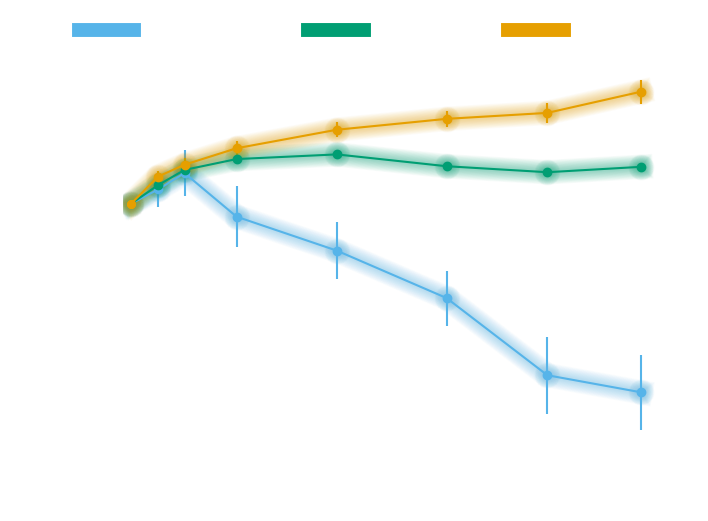

In [6]:
%cd -q $homedir
with plt.rc_context({'text.color': 'white',
                     'axes.labelcolor': 'white',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'axes.edgecolor': 'white',
                     'figure.facecolor': 'FFFFFF', # Transparent 
                     'axes.facecolor': 'FFFFFF',
                     'axes.linewidth': 3,
                     'font.family': 'Times New Roman',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': 'Times New Roman',
                     'mathtext.it': 'Times New Roman:italic',
                     'mathtext.bf': 'Times New Roman:bold',
                     'text.usetex': True,
                     'figure.figsize': (8.25, 4.45),
                     }):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    
    ax.errorbar(sampled_concentrations_NaCl, lower, yerr=lower_err, marker='o', markersize=6, color='C1')
    ax.errorbar(sampled_concentrations_NaCl, bar,   yerr=bar_err,   marker='o', markersize=6, color='C2')
    ax.errorbar(sampled_concentrations_NaCl, upper, yerr=upper_err, marker='o', markersize=6, color='C0')
    
    
    n_lines = 15
    diff_linewidth = 1.05
    alpha_value = 0.03
    
    for y, color in zip([lower, bar, upper], ['C1', 'C2', 'C0']):
        for n in range(1, n_lines+1):
            ax.plot(sampled_concentrations_NaCl, y, linestyle='None', marker='o', markersize=2+(diff_linewidth*n),
                    alpha=alpha_value, color=color)
            ax.plot(sampled_concentrations_NaCl, y, linestyle='solid', linewidth=2+(diff_linewidth*n),
                    alpha=alpha_value, color=color)
            
    # Beautification
    ax.set_ylabel(r'\textbf{Change in excess chemical}'+'\n'+r'\textbf{potential (kcal/mol)}',
                  fontsize=20, labelpad=5)
    ax.set_xlabel(r'\textbf{NaCl concentration (M)}', fontsize=20)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=14, length=3)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    
    xtick_major = np.arange(0, 6)
    xtick_minor = np.arange(0, 5, 0.25)
    ax.set_xlim(-0.1, 5)
    
    lower_patch = Line2D([], [], color='C1', lw=10, label=r'$\boldsymbol{\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}}$')
    BAR_patch   = Line2D([], [], color='C2', lw=10, label=r'$\boldsymbol{\Delta\mu^{\mathrm{ex}}}$')
    upper_patch = Line2D([], [], color='C0', lw=10, label=r'$\boldsymbol{\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}}$')
    
    fig.legend(handles=[lower_patch, BAR_patch, upper_patch], loc='lower center', ncol=3, fontsize=20,
               bbox_to_anchor=(0.5, 0.85), frameon=False)
    
    fig.savefig('Poster/Slvfe_concentration_inequality.pdf', bbox_inches='tight', transparent=True)
    fig.savefig('Poster/Slvfe_concentration_inequality.png', bbox_inches='tight', dpi=600, transparent=True)

## Structure Figure

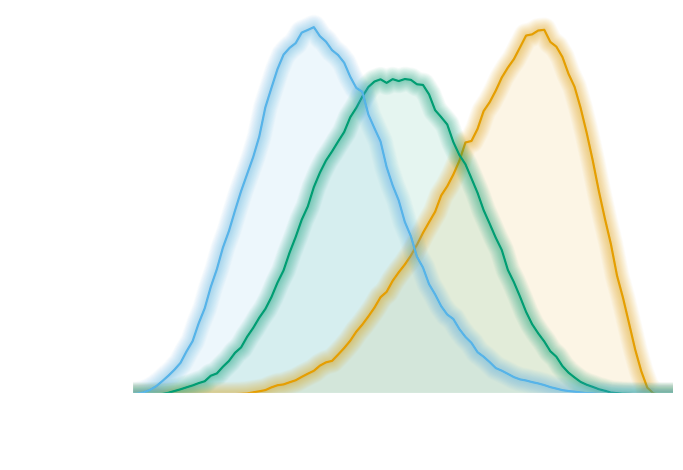

In [7]:
%cd -q $homedir
with plt.rc_context({'text.color': 'white',
                     'axes.labelcolor': 'white',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'axes.edgecolor': 'white',
                     'figure.facecolor': 'FFFFFF', # Transparent 
                     'axes.facecolor': 'FFFFFF',
                     'axes.linewidth': 3,
                     'font.family': 'Times New Roman',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': 'Times New Roman',
                     'mathtext.it': 'Times New Roman:italic',
                     'mathtext.bf': 'Times New Roman:bold',
                     'text.usetex': True,
                     'figure.figsize': (8.25, 4.45),
                     }):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    
    colors = [
        '#e69f00',  # cyan
        '#009e73',  # green
        '#56b4e9',  # orange
    ]
    
    n_lines = 15
    diff_linewidth = 1.05
    alpha_value = 0.03
    
    # Load data
    SASA_wat    = np.load('Data/SASA_PEG36_NaCl_0.00.npy')
    SASA_NaCl_1 = np.load('Data/SASA_PEG36_NaCl_2.00.npy')
    SASA_NaCl_2 = np.load('Data/SASA_PEG36_NaCl_4.00.npy')

    
    data = []
    
    for i, SASA in enumerate([SASA_wat, SASA_NaCl_1, SASA_NaCl_2]):
        y,edges = np.histogram(SASA, bins=100, density=True, range=(15,34))
        centers = 0.5*(edges[1:]+ edges[:-1])
        data.append(y)
        ax.plot(centers,y, linestyle='solid', color=colors[i])
        for n in range(1, n_lines+1):
            ax.plot(centers,y, linestyle='solid', linewidth=2+(diff_linewidth*n), alpha=alpha_value, 
                         color=colors[i])
        ax.fill_between(x=centers, y1=y,y2=0, color=colors[i],alpha=0.1)
    
    ax.set_xlabel(r'\textbf{Solvent accessible surface area (nm$^2$)}', fontsize=20)
    ax.set_ylabel(r'\textbf{Probability distribution}'+'\n'+r'\textbf{function (nm$^{-2}$)}', fontsize=20)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=14, length=3)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(16, 33)
    ax.set_ylim(0, 0.19)
    
    fig.savefig('Poster/SASA.pdf', bbox_inches='tight', transparent=True)
    fig.savefig('Poster/SASA.png', bbox_inches='tight', dpi=600, transparent=True)

## Kirkwood-Buff: Simulations vs Experiment 

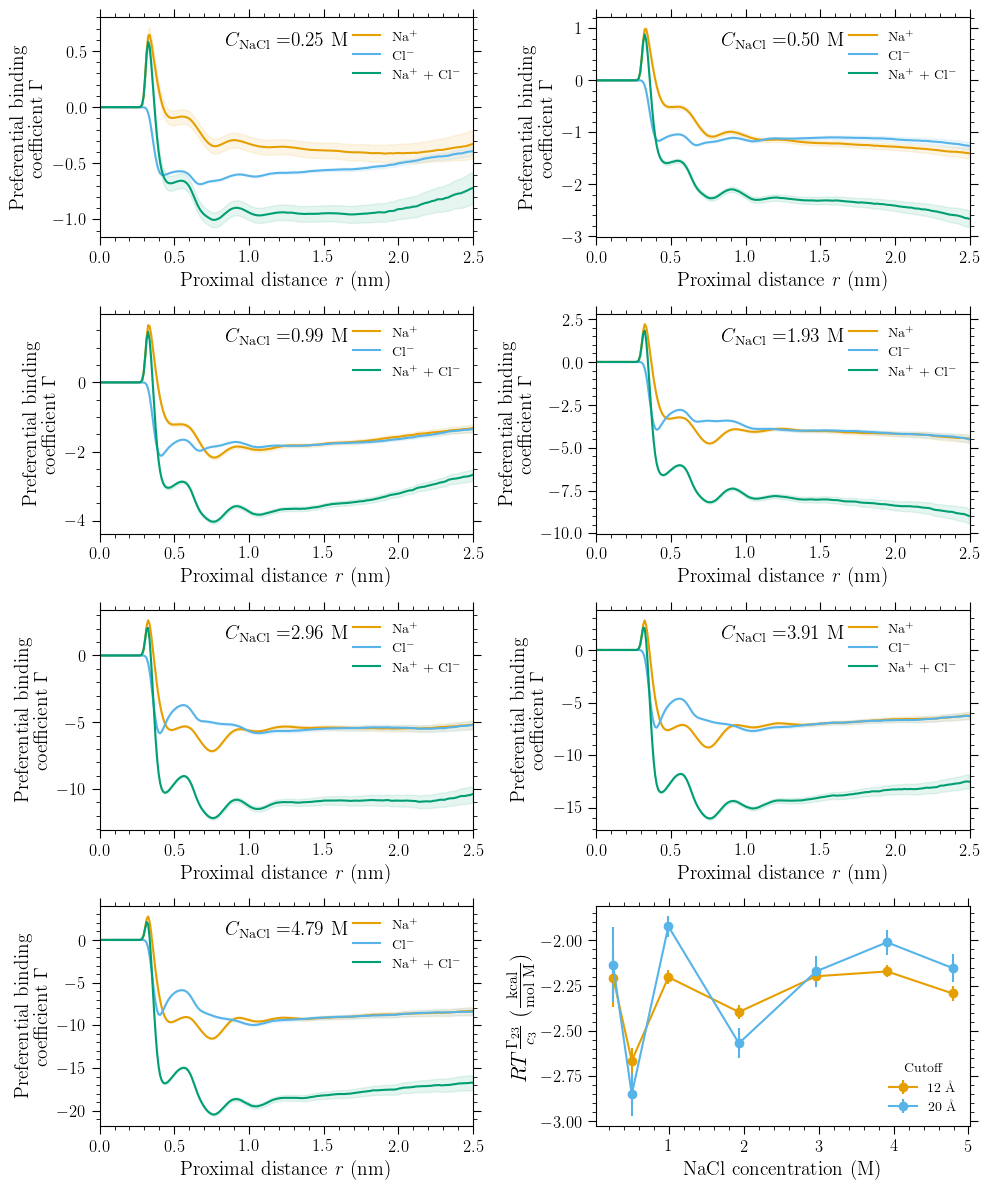

In [8]:
AVOGADRO_CONSTANT = 6.02214076e23
NM3_TO_L = 1e-24

def N_running(r, g_r, g_r_err):
    """
    Compute the running coordination number N(r) by integrating the radial
    distribution function (RDF) with error propagation.
    
    The RDF, g(r), is integrated as:
    
        N(r) = 4 * pi * ∫_0^r g(r') r'^2 dr'
    
    using the trapezoidal rule. The errors on g(r) (provided as g_r_err) are assumed
    to be 95% confidence intervals, e.g., computed as:
    
        g_r_err = PDF_blocks.std(axis=0) / np.sqrt(5) * 1.96
    
    This function propagates these errors assuming that the uncertainties in different 
    bins are uncorrelated.
    
    Parameters
    ----------
    r : np.ndarray
        1D array of distance values.
    g_r : np.ndarray
        1D array of the radial distribution function values evaluated at r.
    g_r_err : np.ndarray
        1D array of errors (95% confidence intervals) associated with g_r.
        
    Returns
    -------
    N : np.ndarray
        The running coordination number, computed as
        N(r) = 4 * pi * ∫_0^r g(r') * r'^2 dr'.
    N_err : np.ndarray
        The propagated error on N(r) (also 95% confidence intervals).
    """
    # Compute the integrand and its error:
    # f(r) = g(r) * r^2, and the error on f is:
    # sigma_f = r^2 * g_r_err.
    f     = g_r * r**2
    f_err = g_r_err * r**2

    # Calculate the differences between successive r-values.
    dx = np.diff(r)
    
    # For the trapezoidal rule, the contribution from the interval [r_i, r_{i+1}] is:
    # dI = (dx/2) * (f[i] + f[i+1])
    dI = dx / 2 * (f[:-1] + f[1:])
    
    # Propagate the errors for each interval assuming the errors in f are independent:
    # The variance of dI is:
    # dI_var = (dx/2)^2 * (f_err[i]^2 + f_err[i+1]^2)
    dI_var = (dx / 2)**2 * (f_err[:-1]**2 + f_err[1:]**2)
    
    # Compute the cumulative integral and its variance.
    # We prepend a zero to start at r=0.
    I_cum     = np.concatenate(([0.0], np.cumsum(dI)))
    I_err_cum = np.concatenate(([0.0], np.sqrt(np.cumsum(dI_var))))
    
    # Multiply by 4*pi to obtain the running coordination number and its error.
    N     = 4 * np.pi * I_cum
    N_err = 4 * np.pi * I_err_cum
    
    return N, N_err


def propagate_Gamma23(r, PDF_data, PDF_err, Nwater, Nions, Ncations, V):
    Gamma23s = []
    Gamma23_errs = []

    for j, (PDF, PDF_e) in enumerate(zip(PDF_data[1:], PDF_err[1:])):
        N1 = Nwater
        N3 = Nions if j == 0 else Ncations

        # Compute N(r) and its error
        N1_r, N1_r_err = N1/V * np.array(N_running(r, PDF_data[0], PDF_err[0]))
        N3_r, N3_r_err = N3/V * np.array(N_running(r, PDF, PDF_e))

        # Compute N1 - N1_r and its propagated error
        N1_minus_N1r = N1 - N1_r
        N1_minus_N1r_err = np.sqrt(0 + N1_r_err**2)  # Assuming N1 has no error

        # Compute N3 - N3_r and its propagated error
        N3_minus_N3r = N3 - N3_r
        N3_minus_N3r_err = np.sqrt(0 + N3_r_err**2)  # Assuming N3 has no error

        # Compute fraction (N3 - N3_r) / (N1 - N1_r)
        fraction = N3_minus_N3r / N1_minus_N1r
        fraction_err = np.abs(fraction) * np.sqrt(
            (N3_minus_N3r_err / N3_minus_N3r)**2 + (N1_minus_N1r_err / N1_minus_N1r)**2
        )

        # Compute Gamma23 and its error
        Gamma23 = N3_r - N1_r * fraction
        Gamma23_err = np.sqrt(
            N3_r_err**2 + (fraction * N1_r_err)**2 + (N1_r * fraction_err)**2
        )

        Gamma23s.append(Gamma23)
        Gamma23_errs.append(Gamma23_err)

    return Gamma23s, Gamma23_errs

# Main program
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,12))
flat_ax = axes.flatten()

i = 0
pref_binding_12Angstrom = []
pref_binding_20Angstrom = []
pref_binding_12Angstrom_errs = []
pref_binding_20Angstrom_errs = []

Gamma23_running = []
Gamma23_running_err = []

salt_concs = []
for conc in salt_reference_concentrations:
    conc = '{0:.2f}'.format(float(conc))
    if conc == '0.00':
        continue
    V = np.loadtxt('Simulations/PEG36mer/NaCl/{}/Solute/output.dat'.format(conc), usecols=(4), skiprows=1)
    V = np.mean(V)
    
    f = open('Simulations/PEG36mer/NaCl/{}/Solute/packmol.in'.format(conc))
    lines = f.readlines()
    f.close()
    Nanions  = float(re.findall(r'\b\d+\b',lines[14])[0])
    Ncations = Nanions
    Nions    = Nanions + Nanions
    Nwater   = Nparticles['Water']
    
    PDF_data = []
    PDF_err  = []
    for solvent in ['water', 'ions', 'Na', 'Cl']:
        PDF_blocks = np.zeros(shape=(5,250))
        for block in range(5):
            container = np.load('Data/PDF_block_averaging/PDF_PEG36_{c}_peg-{solvent}_block{block}.npz'.format(c=conc, solvent=solvent,block=block))
            data = [container[key] for key in container]
            PDF_blocks[block,:] = data[1]
        
        PDF_data.append(PDF_blocks.mean(axis=0))
        PDF_err.append(PDF_blocks.std(axis=0)/np.sqrt(5)*1.96)
    
    r = data[0]
    
    # Preferential binding on the form: Gamma23(r)=N3(r)-N1(r)*(N3-N3(r))/(N1-N1(r))
    Gamma23s = []
    Gamma23_errs = []

    for j, (PDF, PDF_e) in enumerate(zip(PDF_data[1:], PDF_err[1:])):
        N1 = Nwater
        N3 = Nions if j == 0 else Ncations

        # Compute N(r) and its error
        N1_r, N1_r_err = N1/V * np.array(N_running(r, PDF_data[0], PDF_err[0]))
        N3_r, N3_r_err = N3/V * np.array(N_running(r, PDF, PDF_e))

        # Compute N1 - N1_r and its propagated error
        N1_minus_N1r = N1 - N1_r
        N1_minus_N1r_err = np.sqrt(0 + N1_r_err**2)  # Assuming N1 has no error

        # Compute N3 - N3_r and its propagated error
        N3_minus_N3r = N3 - N3_r
        N3_minus_N3r_err = np.sqrt(0 + N3_r_err**2)  # Assuming N3 has no error

        # Compute fraction (N3 - N3_r) / (N1 - N1_r)
        fraction = N3_minus_N3r / N1_minus_N1r
        fraction_err = np.abs(fraction) * np.sqrt(
            (N3_minus_N3r_err / N3_minus_N3r)**2 + (N1_minus_N1r_err / N1_minus_N1r)**2
        )

        # Compute Gamma23 and its error
        Gamma23 = N3_r - N1_r * fraction
        Gamma23_err = np.sqrt(
            N3_r_err**2 + (fraction * N1_r_err)**2 + (N1_r * fraction_err)**2
        )

        Gamma23s.append(Gamma23)
        Gamma23_errs.append(Gamma23_err)

        
    # Store running array for future analysis
    Gamma23_running.append(Gamma23s[0])
    Gamma23_running_err.append(Gamma23_errs[0])
    
    # Define the slice indices
    idx_12A = 120
    idx_20A = 200
    
    # Compute the denominator (constant part)
    denominator = Ncations / (V * NM3_TO_L * AVOGADRO_CONSTANT)
    
    # Compute the preferential binding values
    pref_binding_12Angstrom.append(RT * Gamma23s[0][idx_12A] / denominator)
    pref_binding_20Angstrom.append(RT * Gamma23s[0][idx_20A] / denominator)
    
    # Compute the propagated errors
    pref_binding_12Angstrom_err = RT * Gamma23_errs[0][idx_12A] / denominator
    pref_binding_20Angstrom_err = RT * Gamma23_errs[0][idx_20A] / denominator
    
    # Append errors for storing them
    pref_binding_12Angstrom_errs.append(pref_binding_12Angstrom_err)
    pref_binding_20Angstrom_errs.append(pref_binding_20Angstrom_err)
    salt_concs.append(Ncations/(V*NM3_TO_L*AVOGADRO_CONSTANT))
    
    labels = ['Na$^{+}$', 'Cl$^{-}$', 'Na$^{+}$ + Cl$^{-}$']
    
    for j, (pref_binding, pref_binding_err) in enumerate(zip([Gamma23s[1], Gamma23s[2], Gamma23s[0]], [Gamma23_errs[1], Gamma23_errs[2], Gamma23_errs[0]])):
        flat_ax[i].plot(r, pref_binding, label=labels[j], color='C{}'.format(j), linestyle='solid')
        flat_ax[i].fill_between(r, y1=pref_binding-pref_binding_err, y2=pref_binding+pref_binding_err,
                                color='C{}'.format(j), alpha=0.1)
    
    flat_ax[i].set_title(r'$C_{\mathrm{NaCl}}=$'+'{:.2f} M'.format(Ncations/(V*NM3_TO_L*AVOGADRO_CONSTANT)),
                         fontsize=14, pad=-20, y=1.000001)
    i+=1

flat_ax[-1].errorbar(salt_concs, np.array(pref_binding_12Angstrom), yerr=pref_binding_12Angstrom_errs, marker='o', label='12 Å')
flat_ax[-1].errorbar(salt_concs, np.array(pref_binding_20Angstrom), yerr=pref_binding_20Angstrom_errs, marker='o', label='20 Å')

for ax in flat_ax[0:7]:
    ax.set_xlabel('Proximal distance $r$ (nm)', fontsize=14)
    ax.set_ylabel('Preferential binding\ncoefficient $\Gamma$', fontsize=14)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=12, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.legend(loc='upper right', frameon=False)
    ax.set_xlim(0, 2.5)
    
flat_ax[-1].set_xlabel('NaCl concentration (M)', fontsize=14)
flat_ax[-1].set_ylabel(r'$RT \frac{\Gamma_{23}}{c_3}$ ($\frac{\textrm{kcal}}{\textrm{mol M}}$)',
                       fontsize=16)
flat_ax[-1].minorticks_on()
flat_ax[-1].tick_params(axis='both', which='major', labelsize=12, length=6)
flat_ax[-1].tick_params(axis='both', which='minor', labelsize=12, length=3)
flat_ax[-1].yaxis.set_ticks_position('both')
flat_ax[-1].xaxis.set_ticks_position('both')
flat_ax[-1].legend(loc='best', frameon=False, title='Cutoff')
    
fig.tight_layout()

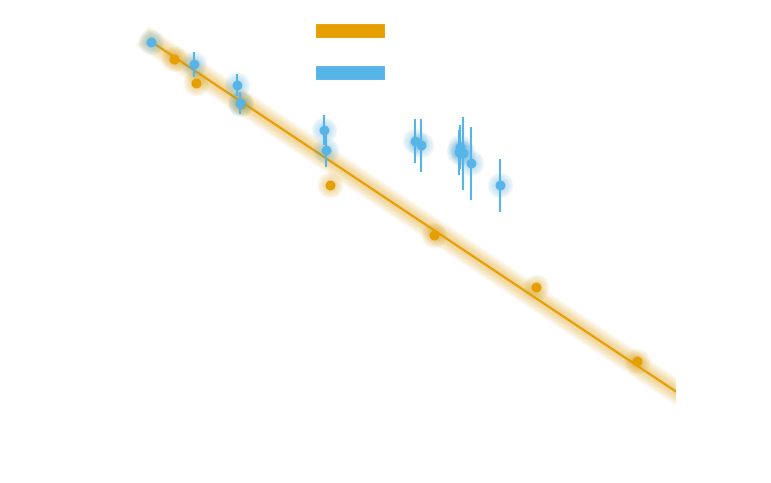

In [10]:
%cd -q $homedir
with plt.rc_context({'text.color': 'white',
                     'axes.labelcolor': 'white',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'axes.edgecolor': 'white',
                     'figure.facecolor': 'FFFFFF', # Transparent 
                     'axes.facecolor': 'FFFFFF',
                     'axes.linewidth': 3,
                     'font.family': 'Times New Roman',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': 'Times New Roman',
                     'mathtext.it': 'Times New Roman:italic',
                     'mathtext.bf': 'Times New Roman:bold',
                     'text.usetex': True,
                     'figure.figsize': (8.25, 4.45),
                     }):
    
    colors = [
        '#e69f00',  # cyan
        '#56b4e9',  # orange
    ]
    
    n_lines = 15
    diff_linewidth = 1.05
    alpha_value = 0.03

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

    def linear_function(x, a):
        return a*x
    
    Gamma23s = np.zeros(shape=(len(Gamma23_running)))
    Gamma23s_err = np.zeros(shape=(2, len(Gamma23_running))) # we assume non-symmetric errors 
    
    for i, (Gamma23, Gammar23_err) in enumerate(zip(Gamma23_running, Gamma23_running_err)):
        # Compute the unadjusted mean for the converged region
        tmp_mean = Gamma23[idx_12A:idx_20A].mean()
        Gamma23s[i] = tmp_mean
        
        # Compute adjusted values for lower and upper errors
        lower_adjusted = Gamma23[idx_12A:idx_20A] - Gammar23_err[idx_12A:idx_20A]
        upper_adjusted = Gamma23[idx_12A:idx_20A] + Gammar23_err[idx_12A:idx_20A]
        
        # Calculate fluctuation errors on the adjusted data
        lower_error = lower_adjusted.mean() - lower_adjusted.min()
        upper_error = upper_adjusted.max() - upper_adjusted.mean()
        
        Gamma23s_err[0, i] = lower_error
        Gamma23s_err[1, i] = upper_error
        
    
    Gamma23s *= 0.5 * 1/36      # 0.5 from converting from ion concentration to ion pair concentration
    Gamma23s_err *= 0.5 * 1/36  # 1/36 from convering PEG-36-mer data into per monomer
    
    # Calculate molarity of systems
    molalities = []
    M_water = 18.015  # g/mol (molar mass of water)
    for Nsalt in salt_reference_concentrations.items():
        Nsalt = Nsalt[1]['P0']
        mass_water_kg = (Nparticles['Water'] * M_water) / (1000)
        molalities.append(Nsalt / mass_water_kg)
    
    
    # Simulation data
    popt, pcov = optimize.curve_fit(linear_function, molalities[1:], Gamma23s)
    perr = 1.96 * np.sqrt(np.diag(pcov))
    ax.plot(molalities[1:], Gamma23s, marker='o', linestyle='None', color=colors[0])
    for n in range(1, n_lines+1):
        ax.plot(molalities[1:], Gamma23s, linestyle='None', marker='o', markersize=2+(diff_linewidth*n),
                alpha=alpha_value, color=colors[0])
    
    x = np.arange(7)
    ax.plot(x, linear_function(x, *popt), linestyle='solid', color='C0')
    for n in range(1, n_lines+1):
        ax.plot(x, linear_function(x, *popt), linestyle='solid', linewidth=2+(diff_linewidth*n),
                alpha=alpha_value, color=colors[0])
    
    # Experimental data
    exp_data = np.loadtxt('Data/Experimental_data/Exp_Gamma.dat', skiprows=1, usecols=(0,1,2), unpack=True)
    ax.errorbar(exp_data[0], exp_data[1], yerr=exp_data[2], marker='o', linestyle='None', color=colors[1])
    for n in range(1, n_lines+1):
        ax.plot(exp_data[0], exp_data[1], linestyle='None', marker='o', markersize=2+(diff_linewidth*n),
                alpha=alpha_value, color=colors[1])
    popt, pcov = optimize.curve_fit(linear_function, exp_data[0], exp_data[1])
    perr = 1.96 * np.sqrt(np.diag(pcov))
    x = np.arange(7)
#    ax.plot(x, linear_function(x, *popt), linestyle='solid', color=colors[1])
#    for n in range(1, n_lines+1):
#        ax.plot(x, linear_function(x, *popt), linestyle='solid', linewidth=2+(diff_linewidth*n),
#                alpha=alpha_value, color=colors[1])
    
    ax.set_xlabel(r'\textbf{NaCl molality (mol/kg)}', fontsize=20)
    ax.set_ylabel(r'\textbf{Preferential binding coefficient}'+'\n'+r'\textbf{$\boldsymbol{\Gamma}$ (salt per monomer)}',
                  fontsize=20)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=14, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=14, length=3)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-0.2, 6)
    
    sim_patch = Line2D([], [], color=colors[0], lw=10, label='Simulation, PEG 36 (inf. dil)')
    exp_patch = Line2D([], [], color=colors[1], lw=10, label='Experiment, PEG 100k (7wt\%)')
    
    fig.legend(handles=[sim_patch, exp_patch], loc='lower center', ncol=1, fontsize=20,
               bbox_to_anchor=(0.7, 0.7), frameon=False)
    
    fig.savefig('Poster/Gamma23_sim_exp.pdf', bbox_inches='tight', transparent=True)
    fig.savefig('Poster/Gamma23_sim_exp.png', bbox_inches='tight', dpi=600, transparent=True)